# Fine-tuning DONUT on the SROIE dataset
##### Using https://www.philschmid.de/fine-tuning-donut as a reference (and some code-theft), but I want to do a few extra things, plus allowing it to happen on a system with no GPUs


In [72]:
import sentencepiece
import tensorboard
import torch
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset
import random
from PIL import Image
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from .train_functions import train_model
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderModel
)

In [2]:
base_path = Path("ICDAR-2019-SROIE/data")
resolution = (720, 960)

### Load and process dataset

In [3]:
task_start_token = "<s>"  # start of task token
eos_token = r"</s>" # eos token of tokenizer
sep = r"</s>"
max_length = 512  # significantly smaller than the model's max length, but makes it easier on the processor

In [4]:
 def json2token(text_json, special_token_list):
    """
    Processes a single entry of the dataset into a string format that DONUT can process
    """
    assert type(text_json) == dict, f"text_json is of type {type(text_json)}, expected dict"
    output = []  # create list and join at end to avoid memory issues
    for k, v in text_json.items():
        # start the sequence
        output.append(fr"<s_{k}>")
        # test if the value is a key
        value = str(v)
        value = f"<{value}/>" if f"<{value}/>" in special_token_list else value
        output.append(value)
        # terminate the sequence
        output.append(fr"</s_{k}>")
    return "".join(output)

In [5]:
def split_dataset(directory, seed=None, train_portion=0.7, val_portion=0.1):
    """
    Splits the data into a train-val-test split
    """
    image_fps = os.listdir(f"{directory}/key")
    ids = [nm[:-5] for nm in image_fps]  # remove the suffix ".json"
    # partition randomly
    rng = np.random.default_rng(seed)
    rng.shuffle(ids)
    train_end = int(train_portion*len(ids))
    val_end = int(val_portion*len(ids)) + train_end
    # deal with the edge case that the dataset is too small
    assert train_end < len(ids), "Train portion overshoots end of data"
    assert val_end < len(ids), "Val portion overshoots end of data"
    train_ids, val_ids, test_ids = ids[:train_end], ids[train_end:val_end], ids[val_end:]
    return train_ids, val_ids, test_ids

In [6]:
# make a custom dataset because loading all images into RAM at once tends to crash my machine
class SROIEDataset(torch.utils.data.Dataset):
    """
    Loads the SROIE dataset into a format that DONUT understands
    """
    def __init__(self, id_list, base_dir):
        self.ids = id_list
        self.base_dir = os.path.abspath(base_dir)
        self.special_tokens = []
        self.__load_special_tokens()
        
    def __getitem__(self, idx):
        # backloading the effort like this MAY make training slow - but it should mean it can be done on a potato
        record_id = self.ids[idx]
        # load image
        image = Image.open(f"{self.base_dir}/img/{record_id}.jpg").convert("RGB")
        # get text as a json object
        with open(f"{self.base_dir}/key/{record_id}.json") as f:
            text = json.load(f)
        # now parse the json as a donut-parseable string
        donut_target = task_start_token + json2token(text, self.special_tokens) + eos_token
        # bounding boxes - not extracted as DONUT is OCR-free (but could load for a model like LayoutLM)
        return {"image": image, "text": donut_target}
    
    def __len__(self):
        return len(self.ids) 
    
    def __load_special_tokens(self):
        for item in self.ids:
            with open(f"{self.base_dir}/key/{item}.json") as f:
                keys = json.load(f).keys()
            for k in keys:
                if fr"<s_{k}>" not in self.special_tokens: # potentially slow
                    self.special_tokens.extend([fr"<s_{k}>" for k in keys])
                    self.special_tokens.extend([fr"</s_{k}>" for k in keys])

In [7]:
train_ids, val_ids, test_ids = split_dataset(base_path, seed = 42)

In [8]:
train_dataset = SROIEDataset(train_ids, base_path)
val_dataset = SROIEDataset(val_ids, base_path)
val_dataset = SROIEDataset(val_ids, base_path)

#### Test that the dataset class works

In [9]:
train_dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=928x2130 at 0x2874DD95850>,
 'text': '<s><s_company>AEON CO. (M) BHD</s_company><s_date>19/02/2018</s_date><s_address>3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR</s_address><s_total>17.70</s_total></s>'}

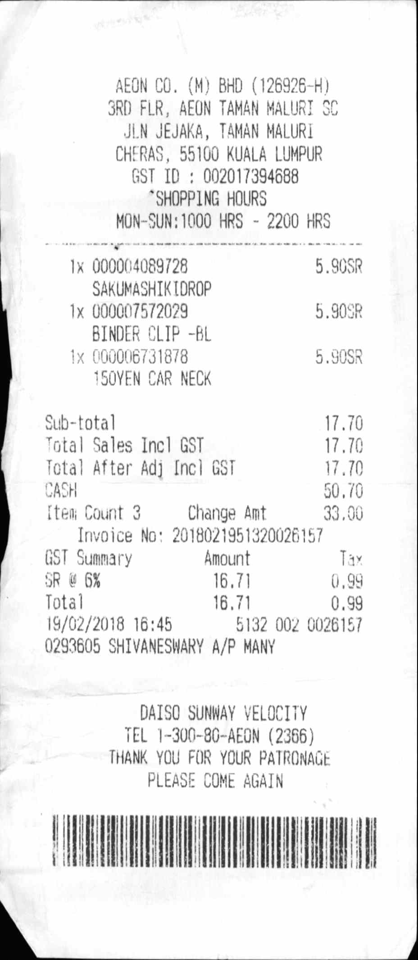

In [10]:
tmp = train_dataset[0]["image"]
tmp.thumbnail(resolution)
tmp

In [11]:
train_dataset[0]["text"]

'<s><s_company>AEON CO. (M) BHD</s_company><s_date>19/02/2018</s_date><s_address>3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR</s_address><s_total>17.70</s_total></s>'

So we've successfully processed the dict into a string that donut understands

In [12]:
train_dataset.special_tokens

['<s_company>',
 '<s_date>',
 '<s_address>',
 '<s_total>',
 '</s_company>',
 '</s_date>',
 '</s_address>',
 '</s_total>']

### Edit model & tokeniser ready for training

In [13]:
# make the tokeniser do the right stuff
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [14]:
# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": train_dataset.special_tokens + 
                                        [task_start_token, eos_token]})

8

In [15]:
processor.image_processor.size = resolution
processor.image_processor.do_align_long_axis = False

In [62]:
# test on our test image - embed and tokenise
output_img = processor(train_dataset[0]["image"], return_tensors="pt")
pixel_values = output_img["pixel_values"]

In [63]:
output_tokens = processor.tokenizer(
    train_dataset[0]["text"],
    add_special_tokens=False,
    max_length=max_length,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

In [64]:
# check the shape of the tensors
pixel_values.shape, output_tokens.shape

(torch.Size([1, 3, 960, 720]), torch.Size([1, 512]))

These are currently batched - we may need to squeeze out the extra dim on the tokeniser output, but overal looks good

Unfortunately, the current dataset isn't ready to be trained on - easiest solution is to wrap it into another dataset. But first, we check what the untrained model does

We will manually run through one pass of the predict part of a training loop to make sure the model trains properly below

In [19]:
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

In [20]:
processor.image_processor.size

(720, 960)

In [21]:
# ignore the warning - CPU only
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = resolution
model.config.decoder.max_length = 1  # test value only - we reset this later
# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57533. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


New embedding size: Embedding(57533, 1024)


In [22]:
task_embedding = processor.tokenizer(
    "<parsing>",
    add_special_tokens=False,
    max_length=max_length,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)

In [65]:
with torch.no_grad():
    embeds = model.forward(pixel_values, decoder_input_ids = task_embedding["input_ids"])

In [24]:
# manual decoding
vocab_dict = processor.tokenizer.get_vocab()
vocab_lookup = {v:k for k,v in vocab_dict.items()}

In [25]:
# most likely token at each step for sanity checking - effecively greedy decoding
most_probable_tokens = embeds.logits.softmax(dim=2).argmax(dim=2).squeeze(0)

In [26]:
# manually decode, just to ensure that the model is functioning properly
decoded = [vocab_lookup[token.item()] for token in most_probable_tokens]
"".join(decoded) # this seems wrong.... but model is also not trained yet

'▁<>>>▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁1▁▁▁▁1▁1▁▁▁▁▁1▁▁1▁1▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁1▁1▁1▁▁1▁1▁1▁▁1▁1▁1▁1▁1▁1,▁1▁1▁1▁1▁1▁1▁1▁1▁1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,'

In [27]:
"".join(processor.batch_decode(most_probable_tokens)) # so "_" is a blank token, and not an underscore

'<>>>111111111111111111,111111111,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,'

This is.... not promising - but it predicts end-to-end, so we move on

### Prepare for training

The previous dataset does not return encoded data, but it would be nice if it did - so nest the dataset in another dataset to make the training code nicer

In [47]:
class DonutDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        # set the processor parameters
        self.processor.image_processor.size = resolution  # downsize for performance
        self.processor.image_processor.do_align_long_axis = False
        self.processor.tokenizer.add_special_tokens({
            "additional_special_tokens": self.dataset.special_tokens + 
                                        [task_start_token, eos_token]})
        # get the task embedding
        self.task_embedding = self.processor.tokenizer(
            "<parsing>",
            add_special_tokens=False,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"]
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        # process the dataset
        proc_img = processor(
            data["image"], 
            return_tensors="pt"
        )["pixel_values"]
        proc_tokens = processor.tokenizer(
            data["text"],
            add_special_tokens=False,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"]
        data_dict = {
            "pixel_values": proc_img,
            "decoder_input_ids": self.task_embedding, 
            "labels": proc_tokens
        }
        return data_dict
        
    def __len__(self):
        return len(self.dataset)

For a quick sanity check, make sure that the dataset will plug into the model as expected

In [48]:
train_donut_ds = DonutDataset(train_dataset, processor)

In [67]:
# test that the dataset is structured correctly
test_example = train_donut_ds[0]
with torch.no_grad():
    embeds = model.forward(**test_example)

In [70]:
# do these seem reasonable?
embeds.loss, embeds.logits.shape, len(embeds.past_key_values)

(tensor(30.3341), torch.Size([1, 512, 57533]), 4)

I'm convinced enough by the above results:
* The loss is extremely poor (as we've seen through manual inspection);
* The logits are of the right shape (batch_size, max_length (or context length), vocab_size); and
* There are 4 previous values for the keys - which is the number of decoder layers

### FIne tune the model

In [ ]:
train_donut_ds = 